# Testing LLaVA 
Testing models and queries. 

**Notes**
- Kernel: `/home/mjcho/micromamba/envs/llava` 
- `micromamba` is used for package management

## Data preparation



In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# load the data
label_dat = pd.read_csv('/home/mjcho/Food_Identification/data/label_features_ocr.csv')

# code food_drink_brand
label_dat['food_drink_brand'] = 0
label_dat.loc[(label_dat.food_or_drink == 1) & (label_dat.brand == 0), 'food_drink_brand'] = 1
label_dat.loc[(label_dat.food_or_drink == 1) & (label_dat.brand == 1), 'food_drink_brand'] = 2

# print counts
print(label_dat.food_drink_brand.value_counts())

/var/tmp/ipykernel_152634/2663000194.py:2: DtypeWarning: Columns (771,772,773,774,775,776,778,779,780,781,782,783,784,789,790,791,792,795,797,799,801,802) have mixed types. Specify dtype option on import or set low_memory=False.
  label_dat = pd.read_csv('/home/mjcho/Food_Identification/data/label_features_ocr.csv')


food_drink_brand
0    22965
1      221
2       82
Name: count, dtype: int64


In [8]:
# Compile a dataframe contains all the rows where food_drink_brand is 1 or 2
y_dat = label_dat[label_dat.food_drink_brand != 0]

# Randomly select 3 times the number of rows of y_dat from label_dat where food_drink_brand is 0
n = y_dat.shape[0]
n_rows = 5 * n
# select rows from label_dat where food_drink_brand is 0
n_dat = label_dat[label_dat.food_drink_brand == 0].sample(n=n_rows, random_state=370)

# Combine y_dat and n_dat
dat = pd.concat([y_dat, n_dat], axis=0)
dat.reset_index(drop=True, inplace=True)
print(dat.shape)
dat.head()


(1818, 831)


,image_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,food_or_drink,brand_t,brand_i,brand,pid,image_link,date,time,text,food_drink_brand
0,family_1002321_brynnalana98@gmail.com202105130...,-0.5850,-0.3547,0.01146,-0.3430,-0.2980,0.1302,0.21350,0.2710,0.03014,...,1,0,1,1,family_1002321_brynnalana98@gmail.com,hs-nero-phi-reeves-haitech-appspot-com-family/...,2021-05-13,03:09:10.332000,@ $ 5 $ 8.09 Following For You 197K white wome...,2
1,family_1002321_brynnalana98@gmail.com202105130...,-0.1741,-0.2370,-0.13720,0.3206,-0.3950,0.1630,0.17860,0.4438,0.20970,...,1,0,1,1,family_1002321_brynnalana98@gmail.com,hs-nero-phi-reeves-haitech-appspot-com-family/...,2021-05-13,03:09:15.333000,@ $ 0 8.09 Following For You 197 white women a...,2
2,family_1002321_brynnalana98@gmail.com202105130...,-0.2274,-0.4010,0.05176,0.1183,-0.3530,0.2588,-0.05957,0.4880,0.36500,...,1,0,1,1,family_1002321_brynnalana98@gmail.com,hs-nero-phi-reeves-haitech-appspot-com-family/...,2021-05-13,03:09:20.335000,@ $ 0 8.09 Following For You 7 197K white wome...,2
3,family_1002321_brynnalana98@gmail.com202105130...,-0.2870,-0.5645,0.40060,-0.1080,-0.8384,0.1603,0.01624,0.5780,0.33980,...,1,0,1,1,family_1002321_brynnalana98@gmail.com,hs-nero-phi-reeves-haitech-appspot-com-family/...,2021-05-13,03:09:25.337000,"8.09 For Following You 1 [ 19,7k white women a...",2
4,family_1002321_brynnalana98@gmail.com202105130...,-0.5230,-0.8960,0.01814,0.1549,-0.7550,0.2769,0.02353,0.5884,0.29100,...,1,0,1,1,family_1002321_brynnalana98@gmail.com,hs-nero-phi-reeves-haitech-appspot-com-family/...,2021-05-13,03:09:30.338000,@ $ 8.09 For Following You 197K white women ar...,2


In [18]:
# check if all image_ids in dat exist in the folder /home/mjcho/Food_Identification/labeled_imgs_resized_0.5
img_folder = '/home/mjcho/Food_Identification/labeled_imgs_resized_0.5'
img_files = os.listdir(img_folder)
dat['img_exists'] = dat.image_id.isin(img_files)
print(dat.img_exists.value_counts())

# subset dat to only include rows where img_exists is True
dat = dat[dat.img_exists]

img_exists
True     1733
False      85
Name: count, dtype: int64


In [20]:
# create a folder to store images, then copy images that are in dat.image_id from img_folder to the new folder

import os

# create a folder to store images
img_folder_new = '/home/mjcho/Food_Identification/llava-food_drink_brand'
if not os.path.exists(img_folder_new):
    os.makedirs(img_folder_new)

# copy images
for img in dat.image_id:
    shutil.copy(os.path.join(img_folder, img), os.path.join(img_folder_new, img))   

# save image_id to a csv file
dat[['image_id']].to_csv('/home/mjcho/Food_Identification/data/llava-food_drink_brand_image_id.csv', index=False)

## LLaVA 1.6

In [1]:
%load_ext autoreload
%autoreload 2

from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model
from llava.utils import disable_torch_init
from llava.conversation import conv_templates, SeparatorStyle
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

import torch
import re 
from pathlib import Path
from PIL import Image
from io import BytesIO
import requests
from tqdm import tqdm

from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)

/home/mjcho/micromamba/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Test loading model
# model_path = "liuhaotian/llava-v1.6-mistral-7b"

# tokenizer, model, image_processor, context_len = load_pretrained_model(
#     model_path=model_path,
#     model_base=None,
#     model_name=get_model_name_from_path(model_path)
# )

In [3]:
# model_path = "liuhaotian/llava-v1.5-7b"
# prompt = "What are the things for eating and drinking in this image?"
# image_file = "https://llava-vl.github.io/static/images/view.jpg" # "images/fastfood.jpg"

# args = type('Args', (), {
#     "model_path": model_path,
#     "model_base": None,
#     "model_name": get_model_name_from_path(model_path),
#     "query": prompt,
#     "conv_mode": None,
#     "image_file": image_file,
#     "sep": ",",
#     "temperature": 0,
#     "top_p": None,
#     "num_beams": 1,
#     "max_new_tokens": 512
# })()

# eval_model(args)

In [2]:
# Load model

disable_torch_init()

model_path = "liuhaotian/llava-v1.5-7b" # 
# model_path = "liuhaotian/llava-v1.6-mistral-7b"

model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, model_base = None, model_name = model_name
)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/mjcho/micromamba/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


In [3]:
model.device

device(type='cuda', index=0)

In [4]:
# args
# "model_path": model_path,
# "model_base": None,
# "model_name": get_model_name_from_path(model_path),
# "query": prompt,
# "conv_mode": None,
# "image_file": image_file,
# "sep": ",",
# "temperature": 0,
# "top_p": None,
# "num_beams": 1,
# "max_new_tokens": 512

# choose conv mode
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

temperature = 0
top_p = None
num_beams = 1
max_new_tokens = 512

In [5]:
# format query
qs = "Please analyze the content of the provided image to determine if it contains any food or drink items. If you find no food or drink items in either text or image format, reply with 0. If you find food or drink items that are not branded, reply with 1. If you find food or drink items that are branded, reply with 2." 
image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
if IMAGE_PLACEHOLDER in qs:
    if model.config.mm_use_im_start_end:
        qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
    else:
        qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
else:
    if model.config.mm_use_im_start_end:
        qs = image_token_se + "\n" + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

In [6]:
def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


In [51]:
# load images
image_files =  Path("images").glob("*.jpeg")
# convert image_files to list of strings
image_files = [str(image_file) for image_file in image_files]
print(image_files)
# images = load_images(image_files)
images = [load_image(image_files[0])]
image_sizes = [x.size for x in images]
images_tensor = process_images(
    images,
    image_processor,
    model.config
).to(model.device, dtype=torch.float16)

# check
print(type(images_tensor))
print(images_tensor.shape)
print(images_tensor.device)

['images/fastfood.jpeg', 'images/tacobell.jpeg']
<class 'torch.Tensor'>
torch.Size([1, 3, 336, 336])
cuda:0


In [33]:
conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

In [21]:
input_ids = (
    tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
    .unsqueeze(0)
    .cuda()
)

NameError: name 'prompt' is not defined

In [52]:
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        image_sizes=image_sizes,
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        use_cache=False,
    )

outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(outputs)

/home/mjcho/micromamba/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/mjcho/micromamba/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2


In [53]:
outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
print(outputs)

2


## Iterate over image files

In [7]:
conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = (
    tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
    .unsqueeze(0)
    .cuda()
)

In [8]:
# load images
image_files =  Path("/home/mjcho/Food_Identification/llava-food_drink_brand").glob("*.jpg")
# convert image_files to list of strings
image_files = [str(image_file) for image_file in image_files]
# print(image_files)
# images = load_images(image_files)


In [57]:
len(image_files)

1733

In [61]:
outputs = []
for image_file in tqdm(image_files):
    images = [load_image(image_file)]
    image_sizes = [x.size for x in images]
    images_tensor = process_images(
        images,
        image_processor,
        model.config
    ).to(model.device, dtype=torch.float16)


    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            image_sizes=image_sizes,
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            top_p=top_p,
            num_beams=num_beams,
            max_new_tokens=max_new_tokens,
            use_cache=False,
        )

    output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
    outputs.append(output)

/home/mjcho/micromamba/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/mjcho/micromamba/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [69]:
# convert outputs to int64 then add to dat as llava_food_drink_brand
dat['llava_food_drink_brand'] = outputs
dat['llava_food_drink_brand'] = dat['llava_food_drink_brand'].astype(int)

dat.to_csv('/home/mjcho/Food_Identification/data/llava-food_drink_brand.csv', index=False)

## Evaluate performance

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def show_performance_metric(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    # printing metrics
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)

    ## Plot confusion matrix
    classes = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    # fig, ax = plt.subplots()
    # sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
    #             cbar=False)
    # ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
    #     yticklabels=classes, title="Confusion matrix")
    # plt.yticks(rotation=0)

In [73]:
# add outputs to dat as llava_food_drink_brand
# dat['llava_food_drink_brand'] = outputs
# count values in dat.food_drink_brand
dat.llava_food_drink_brand.value_counts()
# count values in dat.llava_food_drink_brand
dat.llava_food_drink_brand.value_counts()

# compute performance
show_performance_metric(dat.food_drink_brand, dat.llava_food_drink_brand)


Accuracy: 0.7564916330063474
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1430
           1       0.08      0.03      0.04       221
           2       0.07      0.05      0.06        82

    accuracy                           0.76      1733
   macro avg       0.32      0.33      0.32      1733
weighted avg       0.69      0.76      0.72      1733

[[1300   84   46]
 [ 206    7    8]
 [  77    1    4]]


In [10]:
import pandas as pd

# read the data
dat = pd.read_csv('/home/mjcho/Food_Identification/data/llava-food_drink_brand.csv')

# get the image_id of the images that are misclassified
misclassified = dat[dat.food_drink_brand != dat.llava_food_drink_brand]
misclassified[['image_id', 'food_drink_brand', 'llava_food_drink_brand']][:10]

/var/tmp/ipykernel_460745/2495959385.py:4: DtypeWarning: Columns (771,772,773,774,775,776,779,780,781,782,789,790,791,792,795,797,799,801,802) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('/home/mjcho/Food_Identification/data/llava-food_drink_brand.csv')


,image_id,food_drink_brand,llava_food_drink_brand
0,family_1002321_brynnalana98@gmail.com202105130...,2,0
1,family_1002321_brynnalana98@gmail.com202105130...,2,0
2,family_1002321_brynnalana98@gmail.com202105130...,2,0
3,family_1002321_brynnalana98@gmail.com202105130...,2,0
4,family_1002321_brynnalana98@gmail.com202105130...,2,0
5,family_1002321_brynnalana98@gmail.com202105130...,2,0
6,family_1002321_brynnalana98@gmail.com202105130...,2,0
7,family_1002321_brynnalana98@gmail.com202105130...,2,0
8,family_1002321_brynnalana98@gmail.com202105130...,2,0
9,family_1002321_brynnalana98@gmail.com202105130...,2,0


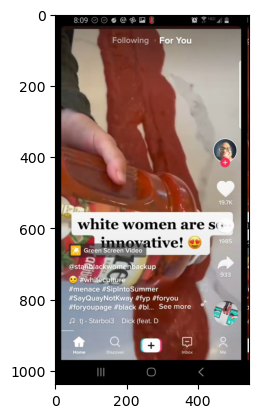

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# plot the first image that are misclassified
img = mpimg.imread(f'/home/mjcho/Food_Identification/labeled_imgs_resized_0.5/{misclassified.iloc[0].image_id}')
imgplot = plt.imshow(img)


In [12]:
images = [load_image(f'/home/mjcho/Food_Identification/labeled_imgs_resized_0.5/{misclassified.iloc[0].image_id}')]
image_sizes = [x.size for x in images]
images_tensor = process_images(
    images,
    image_processor,
    model.config
).to(model.device, dtype=torch.float16)


with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        image_sizes=image_sizes,
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        use_cache=False,
    )

output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
outputs.append(output)

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED